# 1 Task: Foundations

Solve a bin packing task in decision/evalution/search variants.

In [4]:
from typing import List

# Leave the whole “solve_bp_decision” function intact
def solve_bp_decision(items: List[float], n_bins: int) -> bool:
    def able_to_pack(items: List[float], bin_capacities: List[float]) -> bool:
        return items == [] or any( 
            able_to_pack( 
                items[:-1], 
                bin_capacities[:i] + [capacity - items[-1]] + bin_capacities[(i + 1):] 
            ) 
            for i, capacity in enumerate(bin_capacities) if capacity >= items[-1] 
        )

    return able_to_pack( sorted(items), [1.0] * n_bins )

In [45]:
def solve_bp_evaluation(items: List[float]) -> int:
    # bin search
    left = 1; right = len(items) 
    
    while left != right:
        
        curr_idx = left + round((right - left) / 2)
                
        if solve_bp_decision(items, curr_idx):
            right = curr_idx
        else:
            left  = curr_idx + 1 
    
    return right

def merge( packed: List, optimal: int ):
    
    get_weight = lambda x: sum(map(lambda y: y[1], x))
    to_items = lambda packed: [get_weight(x) for x in packed] 
    
    for i in range(len(packed)):
        for j in range(i+1, len(packed)):

            if get_weight( packed[i] ) + get_weight( packed[j] ) <= 1:

                temp = packed.copy()
                temp[i] = temp[i].union( temp[j] )
                temp.pop(j)

                if solve_bp_evaluation( to_items(temp) ) == optimal:
                    packed[i] = packed[i].union( packed[j] )
                    packed.pop(j)
                    return

def solve_bp_search(items: List[float]) -> List[int]:
    
    packed = [{(i, x)} for i, x in enumerate(items)]
    optimal = solve_bp_evaluation(items)
    
    while len(packed) != optimal:
        merge(packed, optimal)
    
    result = [0] * len(items)
    
    for i, bin in enumerate(packed):
        for el in bin:
            result[el[0]] = i + 1
            
    return result

In [43]:
a1 = [1.0]
a2 = [0.19, 0.19, 0.19, 0.19, 0.19]
a3 = [0.09, 0.19, 0.49, 0.29, 0.39, 0.49]
a4 = [0.79, 0.09, 0.39, 0.69]
a5 = [0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.39, 0.39, 0.39]

In [85]:
solve_bp_search(a5)

[1, 1, 2, 2, 3, 3, 1, 2, 3]

# 2 Task: Linear programming

In [ ]:
from scipy.optimize import linprog
import numpy as np
from collections import defaultdict

def read_data():
    
    n_cols, n_rows = map(int, input().split())
    
    w = np.zeros(n_rows)
    matr = np.zeros([n_cols, n_rows])
    
    for i in range(n_rows):
        new = list(map(int, input().split()))
        w[i] = new[0]
        for j in new[1:]:
            matr[j, i] = 1
    
    return w, matr

# Solve lin prog problem

w, matr = read_data()

res = linprog(c=w, A_ub=-matr, b_ub=-np.ones(matr.shape[0]), bounds=[0,1])

# Construct data strucutes for the next step

col_dict = defaultdict(list)
row_list = list(zip(res.x, [[] for x in range(len(res.x))]))

for col, row in zip(*np.nonzero(matr)):
    col_dict[col].append(row)
    row_list[row][1].append(col)

del matr
del res

def make_probs(x):
    s = sum(x)
    return [y/s for y in x]

chosen = []

while col_dict:
    
    col_idx, rows = next(iter(col_dict.items()))
    
    chosen_row = np.random.choice(rows, p=make_probs([row_list[x][0] for x in rows]))
    
    for x in row_list[chosen_row][1]:
        col_dict.pop(x, None)
    
    chosen.append(chosen_row+1)

for x in sorted(chosen):
    print(x, sep=' ', end=' ')

# 3 Task: Branch & Bound

In [26]:
def get_bounds(items: np.recarray, max_vol: float) -> float:
    
    if len(items) == 0:
        return 0
    
    res = linprog(c=-items.val, A_ub=items.vol.reshape(1, -1), b_ub=[max_vol], bounds=[0, 1], method='interior-point')
    
    rounded = prob_round(res.x, items, max_vol)
    
    return items.val @ res.x, items.val @ rounded

In [25]:
def prob_round(xs, items,  max_vol):
    
    curr_vol = 0
    ans = np.zeros(xs.shape[0])
    probs = np.random.rand(xs.shape[0])
    
    for i in range(xs.shape[0]):
        if curr_vol + items[i].vol <= max_vol:
            add = xs[i] >= probs[i]
            curr_vol += items[i].vol*add
            ans[i] = add
    
    return ans

## BFS like

In [196]:
import numpy as np
from scipy.optimize import linprog

# Input

def read_data(test=False):
    
    if test:
        total_volume = 31181
        items_str = """4990 1945
        1142 321
        7390 2945
        10372 4136
        3114 1107
        2744 1022
        3102 1101
        7280 2890
        2624 962
        3020 1060
        2310 805
        2078 689
        3926 1513
        9656 3878
        32708 13504
        4830 1865
        2034 667
        4766 1833
        40006 16553"""
        items_list = []
        for x in items_str.split('\n'):
            vol, val = map(float, x.split())
            if vol <= total_volume:
                items_list.append((vol, val))
    else:
        total_volume = float(input())
        num_obj = int(input())

        items_list = []
        for i in range(num_obj):
            vol, val = map(float, input().split())
            if vol <= total_volume:
                items_list.append((vol, val))    
            
    items = np.array(items_list, dtype=np.dtype([('vol', float), ('val', float)])).view(np.recarray)
    return total_volume, items

# Bounds

def bound_max(items: np.recarray, max_vol: float) -> float:
    
    if len(items) == 0:
        return 0
    
    res = linprog(c=-items.val, A_ub=items.vol.reshape(1, -1), b_ub=[max_vol], bounds=[0, 1], method='interior-point')
    
    return items.val @ res.x

def bound_min(items: np.array, max_vol: float) -> float:

    item_scores = map(lambda x: x.val/x.vol, items)
    
    val, vol = 0, 0
    
    for idx, score in sorted(zip(np.arange(len(items)), item_scores), key=lambda x: x[1], reverse=True):
        if vol + items[idx].vol <= max_vol:
            vol += items[idx].vol
            val += items[idx].val
    return val

# B&B

class Route:
    
    def __init__(self, prev, choice: bool, item: np.recarray, minb, maxb):
    
        if prev is None:
            self.steps = []
            self.minb = 0
            self.maxb = 0
            self.vol = 0
            self.val = 0
        else:
            self.steps = prev.steps.copy()
            self.steps.append(choice)
            
            self.vol = prev.vol + item.vol*choice
            self.val = prev.val + item.val*choice
            self.minb = minb
            self.maxb = maxb
    
    def __str__(self) -> str:
        return "steps: {}, vol: {}, val: {}, minb: {}, maxb: {}".format(self.steps, self.vol, self.val, self.minb, self.maxb)
    
    def __repr__(self) -> str:
        return self.__str__()

def branch(routes, item_idx, items, total_volume):
    '''
    This function bounds optimum values for given prefixes on addition of new item.
    '''
    item = items[item_idx]
    scores = []
    
    for route_idx, route in enumerate(routes):
        for choice in [0, 1]:
            
            curr_items = items[item_idx+1:]
            curr_vol = route.vol + item.vol * choice
            curr_val = route.val + item.val * choice
            
            minb = bound_min(curr_items, total_volume-curr_vol)
            maxb = bound_max(curr_items, total_volume-curr_vol)
            
            scores.append( [route_idx, choice, curr_val+minb, curr_val+maxb] )
    
    return scores

def bound(scores, routes, item, total_volume):
    '''
    Delete branches which are defenetely worse
    '''
    possible = filter(lambda x: routes[x[0]].vol+item.vol*x[1] <= total_volume, scores)
    
    max_min = max(possible, key=lambda x: x[2])[2]
    
    return filter(lambda x: x[3] >= max_min and routes[x[0]].vol+item.vol*x[1] <= total_volume, scores)

In [197]:
%%time 

total_volume, items = read_data(test=True)

routes = [Route(None, None, None, None, None)]

for item_idx, item in enumerate(items):
    
    scores = branch(routes, item_idx, items, total_volume)
    
    new_routes = [Route(prev=routes[step[0]], choice=step[1], item=item, minb=step[2], maxb=step[3]) 
                                         for step in bound(scores, routes, item, total_volume)]
    
    routes = new_routes
    
    #for x in routes:
    #    print(x)
    #print('\n')
    #input()

print(int(max(routes, key=lambda x: x.val).val))

12248
CPU times: user 6.64 s, sys: 84.9 ms, total: 6.73 s
Wall time: 6.61 s


## With priority queue

In [207]:
import numpy as np
from scipy.optimize import linprog

def read_data(test=False):
    
    if test:
        total_volume = 31181
        items_str = """4990 1945
        1142 321
        7390 2945
        10372 4136
        3114 1107
        2744 1022
        3102 1101
        7280 2890
        2624 962
        3020 1060
        2310 805
        2078 689
        3926 1513
        9656 3878
        32708 13504
        4830 1865
        2034 667
        4766 1833
        40006 16553"""
        items_list = []
        for x in items_str.split('\n'):
            vol, val = map(float, x.split())
            if vol <= total_volume:
                items_list.append((vol, val))
    else:
        total_volume = float(input())
        num_obj = int(input())

        items_list = []
        for i in range(num_obj):
            vol, val = map(float, input().split())
            if vol <= total_volume:
                items_list.append((vol, val))    
            
    items = np.array(items_list, dtype=np.dtype([('vol', float), ('val', float)])).view(np.recarray)
    return total_volume, items

def bound(items: np.recarray, max_vol: float) -> float:
    
    item_scores = map(lambda x: x.val/x.vol, items)
    
    val, vol = 0, 0
    max_bound = 0
    
    for idx, score in sorted(zip(np.arange(len(items)), item_scores), key=lambda x: x[1], reverse=True):
        if vol + items[idx].vol <= max_vol:
            vol += items[idx].vol
            val += items[idx].val
        elif max_bound == 0:
            max_bound = val + items[idx].val * (total_volume - vol) / items[idx].vol
            
    return val, max_bound

def bound_min_with_path(items: np.array, max_vol: float) -> float:

    item_scores = map(lambda x: x.val/x.vol, items)
    result = np.zeros(items.shape[0])
    
    val, vol = 0, 0
    
    for idx, score in sorted(zip(np.arange(len(items)), item_scores), key=lambda x: x[1], reverse=True):
        if vol + items[idx].vol <= max_vol:
            vol += items[idx].vol
            val += items[idx].val
            result[idx] = 1
            
    return val, result


class Node:
    
    def __init__(self, obj_id, val, vol, parent, items, total_volume): 
        
        self.obj_id = obj_id
        self.val = val
        self.vol = vol
        self.parent = parent
        self.total_volume = total_volume
        self.items = items
        
        minb, maxb = bound(items[obj_id+1:], total_volume-self.vol)
        self.minb = self.val + minb
        self.maxb = self.val + maxb
        
        self.left = None
        self.right = None
        
    def make_children(self):
        
        if self.obj_id+1 >= self.items.shape[0]:
            left = None
        else:
            left = Node(
                obj_id = self.obj_id+1, 
                val = self.val, 
                vol = self.vol, 
                parent = self, 
                items = self.items, 
                total_volume = self.total_volume
            )
        
        if self.obj_id+1 >= self.items.shape[0] or self.vol + self.items[self.obj_id+1].vol > self.total_volume:
            right = None
        else:
            right = Node(
                obj_id = self.obj_id+1, 
                val = self.val+self.items[self.obj_id+1].val,
                vol = self.vol+self.items[self.obj_id+1].vol,
                parent = self,
                items = self.items,
                total_volume = self.total_volume
            )
            
        self.left = left
        self.right = right
        
        return self.left, self.right
    
    def __lt__(self, other):
        return self.minb > other.minb
    
    def __str__(self):
        
        res = []
        
        if self.left:
            res.extend(map(lambda x: '0 '+ x, str(self.left).split('\n')))
        if self.right:
            res.extend(map(lambda x: '1 '+ x, str(self.right).split('\n')))
            
        if not len(res):
            res.append(': minb:{}, maxb: {}'.format(self.minb, self.maxb))
        return '\n'.join(res)

def construct_branch_from_solution(solution, items, total_volume):
    
    root = Node(
        obj_id=-1,
        val=0,
        vol=0,
        parent=None,
        items = items,
        total_volume = total_volume
    )
    curr_n = root
    
    pq = []    
    for choice in solution:
        left, right = curr_n.make_children()
        
        if choice:
            curr_n = right
            if left:
                pq.append(left)
        else:
            curr_n = left
            if right:
                pq.append(right)
                
    return root, pq

In [210]:
%%time
total_volume, items = read_data(test=True)

best_bound, solution = bound_min_with_path(items, total_volume)

root, pq = construct_branch_from_solution(solution, items, total_volume)

while len(pq):
    
    node = pq.pop()
    
    if node.maxb < best_bound:
        continue
    
    if node.minb > best_bound:
        best_bound = node.minb
    
    left, right = node.make_children()
    
    if left:
        pq.append(left)
    if right:
        pq.append(right)
        
    #print(root)
    #print('best: {}', best_bound)
    #input()

print(int(best_bound))

12248
CPU times: user 3.93 s, sys: 79 ms, total: 4.01 s
Wall time: 3.78 s


In [1]:
# other solution

In [ ]:
from scipy.optimize import linprog
import numpy as np
import sys

V = int(input())
N = int(input())
volumes = [None] * N
prices = [None] * N

for i in range(N):
    raw_in = input().split()
    volumes[i] = int(raw_in[0])
    prices[i]  = int(raw_in[1])

# Sort input greedy
items = sorted(zip(volumes, prices), key=lambda x: -x[1]/x[0])

volumes = np.array([v for v, _ in items])
prices  = np.array([p for _, p in items])

def get_opt(V=V, volumes=volumes, prices=prices):
    sum_price = 0

    for v, p in zip(volumes, prices):
        if V < v:
            return sum_price + p * V/v

        V -= v
        sum_price += p

    return sum_price

sys.setrecursionlimit(10**6)

# Best here is theoretical best (best - current price) for the current part of the tree
def try_take(V=V, volumes=volumes, prices=prices, best=0):
    # No items left
    if len(volumes) == 0:
        return 0
    
    # Optimization for leaves
    if len(volumes) == 1:
        if volumes[0] < V:
            return prices[0]
        else:
            return 0

    if get_opt(V, volumes, prices) <= best:
        return 0

    # Try to add
    if volumes[0] <= V:        
        taken_best = try_take(V - volumes[0], volumes[1:], prices[1:], best - prices[0])
        best = max(taken_best + prices[0], best)
    
    # If we don't add
    not_taken_best = try_take(V, volumes[1:], prices[1:], best)
    best = max(best, not_taken_best)
    return best

print(int(try_take()))

# 4. Euclidian TSP

### Christofides algorithm


In [117]:
import numpy as np
from scipy.spatial import distance_matrix 
import matplotlib.pyplot as plt
from collections import defaultdict

In [332]:
points = np.array([
    [0, 0],
    [1, 2],
    [2, 1],
    [3, 2],
    [0, 5],
    [9, 0],
    [9, 6],
    [10, 0],
    [10, 3],
    [10, 10],
    [5,3],
    [6,4]
])

dist = distance_matrix(example, example)

In [369]:
test = """1 0.0 0.0
2 1.0 0.0
3 1.0 1.0
4 0.0 1.0"""

In [374]:
from collections import defaultdict
import numpy as np
import random
from scipy.spatial import distance_matrix 


n = int(input())
test = ""

for _ in range(n):
    test += input() + '\n'
test.strip('\n')

def read_data(test):

    data = list(map(lambda x: list(map(float, x.split())), test.split('\n')[:-1]))
    d = np.array(data)
    dist = distance_matrix(d[:,1:],d[:,1:])
    
    return dist, d[:, 1:], d[:, 0].astype(int)

dist, points, ids = read_data(test)


# Prima mst
# TODO: add an oct tree here not to do full argmin

def minimum_spanning_tree(X):

    n_vertices = X.shape[0]
    spanning_edges = []
    
    # initialize with node 0:                                                                                         
    visited_vertices = [0]                                                                                            
    num_visited = 1
    
    # exclude self connections:
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf
    
    while num_visited != n_vertices:
        new_edge = np.argmin(X[visited_vertices], axis=None)
        # 2d encoding of new_edge from flat, get correct indices                                                      
        new_edge = divmod(new_edge, n_vertices)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]                                                       
        # add edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                     
        num_visited += 1
    return np.vstack(spanning_edges)

mst = minimum_spanning_tree(dist.copy())

def find_odd(edge_list, num_vert):
    
    degrees = np.zeros(num_vert, dtype=int)
    
    for e in edge_list:
        degrees[e[0]] += 1; degrees[e[1]] += 1
        
    idx = (degrees % 2).astype(bool)
    return np.arange(num_vert)[idx] 
odd = find_odd(mst, points.shape[0])

def minimum_weight_matching(dist, odd_idx, tries = 10):
    
    BEST = float("inf")
    BEST_EDGES = []
    
    for _ in range(tries):
        idx = np.arange(len(odd_idx)).tolist()

        random.shuffle(idx)

        new_edges = []
        total = 0
        while idx:
            v = idx.pop()
            length = float("inf")
            closest_idx = 0

            for i in range(len(idx)):
                u = idx[i]
                step = dist[odd_idx[u], odd_idx[v]]
                if step < length:
                    length = step
                    closest_idx = i
            total += dist[odd_idx[v], odd_idx[idx[closest_idx]]]
            new_edges.append([odd_idx[v], odd_idx[idx[closest_idx]]])
            idx.pop(closest_idx)
            
        if total < BEST:
            BEST = total
            BEST_EDGES = new_edges
            
    return BEST_EDGES

connect = minimum_weight_matching(dist, odd)

# find eulirian path
class Edges:
    def __init__(self):
        self.edges = defaultdict(int)
        self.count = 0
        
    def has(self, e):
        return self.edges[tuple(sorted(e))] != 0
    
    def insert(self, e):
        self.edges[tuple(sorted(e))] += 1
        self.count += 1
        
    def remove(self, e):
        self.edges[tuple(sorted(e))] -= 1
        self.count -= 1

graph = defaultdict(dict)
edge_counter = Edges()

for x in mst:
    graph[x[0]][x[1]] = 1
    graph[x[1]][x[0]] = 1
    edge_counter.insert(x)
    
for x in connect:
    graph[x[0]][x[1]] = 1
    graph[x[1]][x[0]] = 1
    edge_counter.insert(x)

unvisited = list(graph[0].keys())
prev = 0
path = []

while len(unvisited):
    
    node = unvisited.pop()
    
    if node != prev:

        if edge_counter.has([prev, node]):
            path.append([prev, node])
            edge_counter.remove([prev, node])
            unvisited.extend(graph[node].keys())
            prev = node

        if edge_counter.count == 0:
            break

def shortcut(path):
    
    visited = {0: 1}
    prev = 0
    new = []
    
    for x in path:
        if not x[1] in visited:
            new.append([prev, x[1]])
            prev = x[1]
            visited[x[1]] = 1
    
    new.append([prev, 0])
    return new

for x in shortcut(path):
    print(ids[x[0]], end=' ')
print(ids[0])

1 4 3 2 1


##### Much better version

In [522]:
import time

In [540]:
a = time.time()

In [541]:
a

1589920822.7385225

In [544]:
time.time() - a

8.185688972473145

In [520]:
from collections import defaultdict
import numpy as np
import random
from scipy.spatial import distance_matrix 
import time

n = int(input())
test = ""

for _ in range(n):
    test += input() + '\n'
test.strip('\n')

def read_data(test):

    data = list(map(lambda x: list(map(float, x.split())), test.split('\n')[:-1]))
    d = np.array(data)
    dist = distance_matrix(d[:,1:],d[:,1:])
    
    return dist, d[:, 1:], d[:, 0].astype(int)

dist, points, ids = read_data(test)


NUM_ITER = 10

min_len = float("inf")
best_path = []

for _ in range(NUM_ITER):
    idx = np.arange(points.shape[0]).tolist()
    start = prev = np.random.choice(idx); idx.pop(prev)
    path = [start]
    total_len = 0
    
    while idx:
        closest = 0; length = float("inf"); i = 0
        for ind, x in enumerate(idx):
            if dist[prev, x] < length:
                closest = x
                length = dist[prev, x]
                i = ind
        path.append(closest)
        total_len += length
        prev = closest
        idx.pop(i)
        
    total_len += dist[start, path[-1]]
    
    if total_len < min_len:
        best_path = path

def possible_segments(N):
    """ Generate the combination of segments """
    segments = ((i, j, k) for i in range(N) for j in range(i + 2, N-1) for k in range(j + 2, N - 1 + (i > 0)))
    return segments

def get_solution_cost_change(dist, path, case, i, j, k):
    """All 3-opt moves"""
    A, B, C, D, E, F = path[i - 1], path[i], path[j - 1], path[j], path[k - 1], path[k % len(path)]
    # three edges
    if case == 0:
        # first case is the current solution ABC
        return 0
    elif case == 1:
        # second case is the case A'BC
        return dist[A, B] + dist[E, F] - (dist[B, F] + dist[A, E])
    elif case == 2:
        # ABC'
        return dist[C, D] + dist[E, F] - (dist[D, F] + dist[C, E])
    elif case == 3:
        # A'BC'
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[A, D] + dist[B, F] + dist[E, C])
    elif case == 4:
        # A'B'C
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[C, F] + dist[B, D] + dist[E, A])
    elif case == 5:
        # AB'C
        return dist[B, A] + dist[D, C] - (dist[C, A] + dist[B, D])
    elif case == 6:
        # AB'C'
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[B, E] + dist[D, F] + dist[C, A])
    elif case == 7:
        # A'B'C
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[A, D] + dist[C, F] + dist[B, E])

def reverse_segments(route, case, i, j, k):

    if (i - 1) < (k % len(route)):
        first_segment = route[k% len(route):] + route[:i]
    else:
        first_segment = route[k % len(route):i]
    second_segment = route[i:j]
    third_segment = route[j:k]
    
    solution = route 
    
    if case == 0:
        # first case is the current solution ABC
        pass
    elif case == 1:
        # A'BC
        solution = list(reversed(first_segment)) + second_segment + third_segment
    elif case == 2:
        # ABC'
        solution = first_segment + second_segment + list(reversed(third_segment))
    elif case == 3:
        # A'BC'
        solution = list(reversed(first_segment)) + second_segment + list(reversed(third_segment))
    elif case == 4:
        # A'B'C
        solution = list(reversed(first_segment)) + list(reversed(second_segment)) + third_segment
    elif case == 5:
        # AB'C
        solution = first_segment + list(reversed(second_segment)) + third_segment
    elif case == 6:
        # AB'C'
        solution = first_segment + list(reversed(second_segment)) + list(reversed(third_segment))
    elif case == 7:
        # A'B'C
        solution = list(reversed(first_segment)) + list(reversed(second_segment)) + list(reversed(third_segment))
    return solution

EPS = 1
NUM_ITER = 5

for _ in range(NUM_ITER):
    BEST_ADJ = 0
    for x in possible_segments(dist.shape[0]):
        i = x[0]; j = x[1]; k = x[2]
        
        best_move = 0; best_adj = 0
        # try all variants
        for case in range(8):
            adj = get_solution_cost_change(dist, best_path, case, i, j ,k)
            if adj > best_adj:
                best_move = case; best_adj = adj
                
        best_path = reverse_segments(best_path, best_move, i, j, k)

        if best_adj > BEST_ADJ:
            BEST_ADJ = best_adj
    
    if BEST_ADJ <= EPS:
        break

best_path.append(best_path[0])
for x in best_path:
    print(ids[x], end=' ')

4
1 0 0
2 1 0
3 1 1
4 0 1
2 1 0 3 2 

In [518]:
######

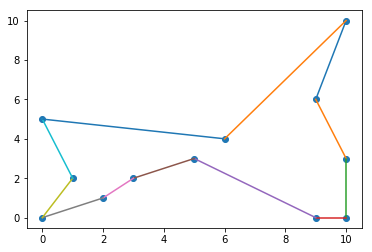

In [515]:
plt.scatter(points[:, 0], points[:, 1])

for i in range(1, len(best_path)):
    p1 = points[best_path[i]]
    p2 = points[best_path[i-1]]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]])

In [375]:
# minimum weight perfect matching

def get_k_num(k_x, k_y, k):
    if k_x % 2 == 0:
        return k_x * k + k_y # even columns
    else:
        return (k_x + 1) * k - k_y - 1# odd columns

def divide_by_cells(example, k):
    
    min = example.min(); max = example.max()
    
    part_length = (max - min) / k
    
    separated = defaultdict(list)
    for i, e in enumerate(example):
        k_x = np.floor((e[0] - min) / part_length)
        k_y = np.floor((e[1] - min) / part_length)
        
        print(e, k_x, k_y, get_k_num(k_x, k_y, k))
        separated[get_k_num(k_x, k_y, k)].append(i)
    
    return separated

#https://web.eecs.umich.edu/~pettie/matching/Iri-Murota-Matsui-approx-planar-mwpm.pdf
#serpantine algorithm (with process and detour)

def weight_perfect(example):
    
    k = int(np.ceil(np.sqrt(example.shape[0])))
    
    cells = divide_by_cells(example, k)
    leftovers = []
    edges = []

    for x in range(k**2):
        if len(cells[x]):
            leftovers.extend(cells[x])

            while len(leftovers) > 1:
                edges.append([leftovers.pop(0), leftovers.pop(0)])
    print('k:',k,'cells:',cells)
    
    return edges

### MIPT 3

In [559]:
from collections import defaultdict
import numpy as np
import random
from scipy.spatial import distance_matrix 
import time

In [560]:
with open('dataset_328552_4.txt') as f:
    d = f.read().split('\n')[:-1]
    n, p, k, M = map(int, d[0].split())
    data = np.array([list(map(int, x.split())) for x in d[1:]])

In [561]:
points = data[:, :2]; prices = data[:, 2]

dist = distance_matrix(points, points)

In [562]:
NUM_ITER = 10

max_val = 0
best_path = []

for _ in range(NUM_ITER):
    idx = np.arange(points.shape[0]).tolist()
    prev = np.random.choice(idx); idx.pop(prev)
    path = [prev]
    value = 0

    while idx:
        closest = 0; length = float("inf"); i = 0
        for ind, x in enumerate(idx):
            if dist[prev, x] < length:
                closest = x
                length = dist[prev, x]
                i = ind
        path.append(closest)
        value += (prices[closest] - p*length)
        prev = closest
        idx.pop(i)
    
    if value > max_val:
        best_path = path

In [563]:
def possible_segments(N):
    """ Generate the combination of segments """
    segments = ((i, j, k) for i in range(N) for j in range(i + 2, N-1) for k in range(j + 2, N - 1 + (i > 0)))
    return segments

def get_solution_cost_change(dist, path, case, i, j, k):
    """All 3-opt moves"""
    A, B, C, D, E, F = path[i - 1], path[i], path[j - 1], path[j], path[k - 1], path[k % len(path)]
    # three edges
    if case == 0:
        # first case is the current solution ABC
        return 0
    elif case == 1:
        # second case is the case A'BC
        return dist[A, B] + dist[E, F] - (dist[B, F] + dist[A, E])
    elif case == 2:
        # ABC'
        return dist[C, D] + dist[E, F] - (dist[D, F] + dist[C, E])
    elif case == 3:
        # A'BC'
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[A, D] + dist[B, F] + dist[E, C])
    elif case == 4:
        # A'B'C
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[C, F] + dist[B, D] + dist[E, A])
    elif case == 5:
        # AB'C
        return dist[B, A] + dist[D, C] - (dist[C, A] + dist[B, D])
    elif case == 6:
        # AB'C'
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[B, E] + dist[D, F] + dist[C, A])
    elif case == 7:
        # A'B'C
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[A, D] + dist[C, F] + dist[B, E])

def reverse_segments(route, case, i, j, k):

    if (i - 1) < (k % len(route)):
        first_segment = route[k% len(route):] + route[:i]
    else:
        first_segment = route[k % len(route):i]
    second_segment = route[i:j]
    third_segment = route[j:k]
    
    solution = route 
    
    if case == 0:
        # first case is the current solution ABC
        pass
    elif case == 1:
        # A'BC
        solution = list(reversed(first_segment)) + second_segment + third_segment
    elif case == 2:
        # ABC'
        solution = first_segment + second_segment + list(reversed(third_segment))
    elif case == 3:
        # A'BC'
        solution = list(reversed(first_segment)) + second_segment + list(reversed(third_segment))
    elif case == 4:
        # A'B'C
        solution = list(reversed(first_segment)) + list(reversed(second_segment)) + third_segment
    elif case == 5:
        # AB'C
        solution = first_segment + list(reversed(second_segment)) + third_segment
    elif case == 6:
        # AB'C'
        solution = first_segment + list(reversed(second_segment)) + list(reversed(third_segment))
    elif case == 7:
        # A'B'C
        solution = list(reversed(first_segment)) + list(reversed(second_segment)) + list(reversed(third_segment))
    return solution

EPS = 500
NUM_ITER = 3

for _ in range(NUM_ITER):
    BEST_ADJ = 0
    for x in possible_segments(dist.shape[0]):
        i = x[0]; j = x[1]; k = x[2]
        
        best_move = 0; best_adj = 0
        # try all variants
        for case in range(8):
            adj = get_solution_cost_change(dist, best_path, case, i, j ,k)
            if adj > best_adj:
                best_move = case; best_adj = adj
                
        best_path = reverse_segments(best_path, best_move, i, j, k)

        if best_adj > BEST_ADJ:
            BEST_ADJ = best_adj
    
    if BEST_ADJ <= EPS:
        break

KeyboardInterrupt: 

In [564]:
def print_path(path):
    start = np.argmax([x == 0 for x in path])
    for x in range(start, len(path)):
        print(path[x]+1, end=' ')
    for x in range(start):
        print(path[x]+1, end=' ')
    print('1')

In [565]:
print_path(best_path)

1 800 175 428 829 159 164 339 878 741 266 921 480 489 763 95 441 657 346 900 165 683 190 775 966 834 325 174 939 472 134 427 376 61 975 478 764 506 931 315 516 12 711 776 203 760 15 637 476 601 503 740 145 735 929 305 163 302 944 930 124 62 4 169 150 88 549 572 199 893 160 589 483 565 221 737 452 397 951 235 587 13 703 237 671 627 811 321 202 30 566 222 507 357 398 3 708 329 895 420 204 805 394 855 965 283 559 575 207 821 10 861 120 412 515 841 962 149 833 167 301 819 865 807 697 449 240 239 49 722 586 285 796 157 170 67 276 547 341 208 770 224 191 885 22 229 424 114 35 903 758 617 881 33 695 523 40 897 299 497 673 607 866 16 453 555 288 882 720 592 552 752 373 806 509 289 571 129 201 919 360 74 785 176 660 902 801 971 328 830 721 334 825 85 63 108 468 322 959 58 261 344 689 934 940 103 158 295 435 185 326 686 772 94 799 576 311 267 31 29 876 282 111 956 455 440 98 345 648 292 528 294 64 964 410 393 456 494 615 668 635 653 438 25 522 255 404 531 645 79 245 569 193 275 835 618 551 384 3

# 5. Genetic set cover

In [521]:
data = """1 1 2 6 9
1 0 2 7 10
1 0 1 8 11
1 0 4 5 9
1 1 3 5 10
1 2 3 4 11
1 3 7 8 9
1 4 6 8 10
1 5 6 7 11"""